# Dataset Description and Features
We have used handwritten notes for the dataset, mainly 100 per person. Each image will belong to one of three categories Mehdy, Umair, and Hasnain. Each image has been labeled i.e. author_img (100).jpg. Dataset when loaded in pandas will have two columns (features) mainly file_path and label.

# Imported Libraries

Required to install:
pip install numpy
pip install pillow
pip install matplot
pip install seaborn
pip install scikit-image
pip install scikit-learn
pip install torch
pip install openyxl

In [45]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

# Paths Defination

In [46]:
# Define the path to the dataset
orignal_images_path = 'orignal_images/'


#  Applying GSCM, Preprocessing with Pandas

The dataset is split into training and testing sets to evaluate the model's performance. Features are scaled using StandardScaler to improve convergence and performance. A K-Nearest Neighbors (K-NN) classifier is trained using GridSearchCV for hyperparameter tuning, optimizing parameters such as the number of neighbors and distance metric.

In [47]:
def extract_glcm_features(image_path):
    with Image.open(image_path) as image:
        grayscale_image = image.convert('L')
        grayscale_image_np = np.array(grayscale_image)
        glcm = graycomatrix(grayscale_image_np, [1], [0], 256, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]
        correlation = graycoprops(glcm, 'correlation')[0, 0]
        return [contrast, dissimilarity, homogeneity, energy, correlation]


features = []
labels = []
for file_name in os.listdir(orignal_images_path):
    file_path = os.path.join(orignal_images_path, file_name)
    label = file_name.split('_')[0]
    features.append(extract_glcm_features(file_path))
    labels.append(label)

df = pd.DataFrame(features, columns=['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation'])
df['label'] = labels
df.to_excel('features.xlsx', index=False)


# Data Preparation and Training Setup

In [48]:
df = pd.read_excel('features.xlsx')
X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# K-Nearest Neighbors (KNN) Classifier with Grid Search

In [49]:
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],  
    'metric': ['euclidean', 'manhattan']  
}
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

print(f"Best Parameters: {grid_search.best_params_}")

y_pred = grid_search.predict(X_test_scaled)


Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}


# Classification Report

In [50]:
report_dict = classification_report(y_test, y_pred,output_dict=True)

for class_label, metrics in report_dict.items():
    if class_label in ['accuracy', 'macro avg', 'weighted avg']:
        continue
    
    # Process the metrics for each class
    precision = metrics['precision']
    recall = metrics['recall']
    f1_score = metrics['f1-score']
    support = metrics['support']
    
    print(f"Class: {class_label}")
    print(f" Precision: {precision}")
    print(f" Recall: {recall}")
    print(f" F1 Score: {f1_score}")
    print(f" Support: {support}")
    print()


Class: hasnain
 Precision: 1.0
 Recall: 0.9545454545454546
 F1 Score: 0.9767441860465117
 Support: 22.0

Class: mehdy
 Precision: 0.9130434782608695
 Recall: 1.0
 F1 Score: 0.9545454545454545
 Support: 21.0

Class: umair
 Precision: 1.0
 Recall: 0.9473684210526315
 F1 Score: 0.972972972972973
 Support: 19.0



# Accuracy and Confusion Matrix Visualization

Overall Accuracy: 96.77%


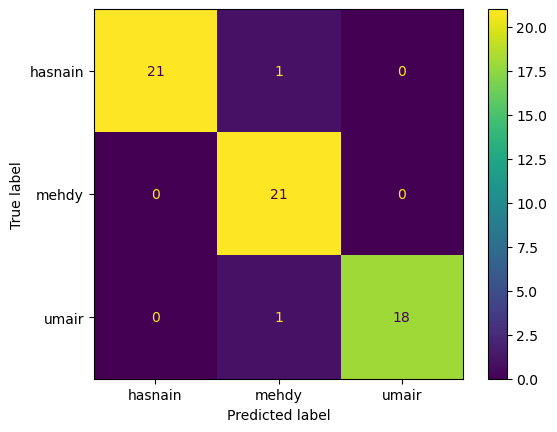

In [51]:
# Calculate the overall accuracy
accuracy = report_dict.get('accuracy')
print(f"Overall Accuracy: {accuracy * 100:.2f}%")


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
disp.plot()
plt.show()

The Handwriting Classification System evaluates the model's performance using essential classification metrics, including accuracy, precision, recall, and F1-score. These metrics offer comprehensive insights into the model's ability to correctly classify handwritten images. The classification report provides a detailed breakdown of these metrics for each class, facilitating a nuanced understanding of the model's strengths and weaknesses. Additionally, the confusion matrix visually compares the model's predictions to the actual labels, offering further granularity in assessing its performance across different classes.

# Writer Prediction

In [52]:

def predict_single_image(image_path, model, scaler):
    features = extract_glcm_features(image_path)
    feature_names = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    features_df = pd.DataFrame([features], columns=feature_names)
    features_scaled = scaler.transform(features_df)
    prediction = model.predict(features_scaled)
    return prediction,features_df

check_image_path = 'Final checking/Hasnain/has.jpg'
predicted_label,features_df = predict_single_image(check_image_path, grid_search.best_estimator_, scaler)
print(f"Predicted label for image {check_image_path}: {predicted_label}")
check_image_path = 'Final checking/Mehdy/IMG-20240504-WA0032.jpg'
predicted_label,features_df = predict_single_image(check_image_path, grid_search.best_estimator_, scaler)
print(f"Predicted label for image {check_image_path}: {predicted_label}")
check_image_path = 'Final checking/Umair/IMG-20240504-WA0044.jpg'
predicted_label,features_df = predict_single_image(check_image_path, grid_search.best_estimator_, scaler)
print(f"Predicted label for image {check_image_path}: {predicted_label}")

Predicted label for image Final checking/Hasnain/has.jpg: ['hasnain']
Predicted label for image Final checking/Mehdy/IMG-20240504-WA0032.jpg: ['mehdy']
Predicted label for image Final checking/Umair/IMG-20240504-WA0044.jpg: ['umair']


# Outliers

In [53]:

Q1 = features_df.quantile(0.25)
Q3 = features_df.quantile(0.75)
IQR = Q3 - Q1

outliers = (features_df < (Q1 - 1.5 * IQR)) | (features_df > (Q3 + 1.5 * IQR))
outlier_counts = outliers.sum()
print(f"Number of outliers in each feature:\n{outlier_counts}")


Number of outliers in each feature:
contrast         0
dissimilarity    0
homogeneity      0
energy           0
correlation      0
dtype: int64


# The dtype, Dimensionality and Descriptive Statistics  

In [54]:
print(df.dtypes)
print()
print(df.shape)
print()
print(df.describe())
print()

contrast         float64
dissimilarity    float64
homogeneity      float64
energy           float64
correlation      float64
label             object
dtype: object

(309, 6)

         contrast  dissimilarity  homogeneity      energy  correlation
count  309.000000     309.000000   309.000000  309.000000   309.000000
mean    91.643270       3.916673     0.460657    0.144878     0.965225
std     55.297357       1.650890     0.218424    0.230782     0.012072
min     11.303209       0.890028     0.136618    0.020415     0.906603
25%     47.779757       2.963947     0.320144    0.037632     0.958337
50%     79.446240       3.507947     0.414919    0.049045     0.966469
75%    125.302793       4.398192     0.592517    0.075610     0.973766
max    310.440595       8.895455     0.935431    0.901156     0.990959



# Data Visualization with Matplotlib

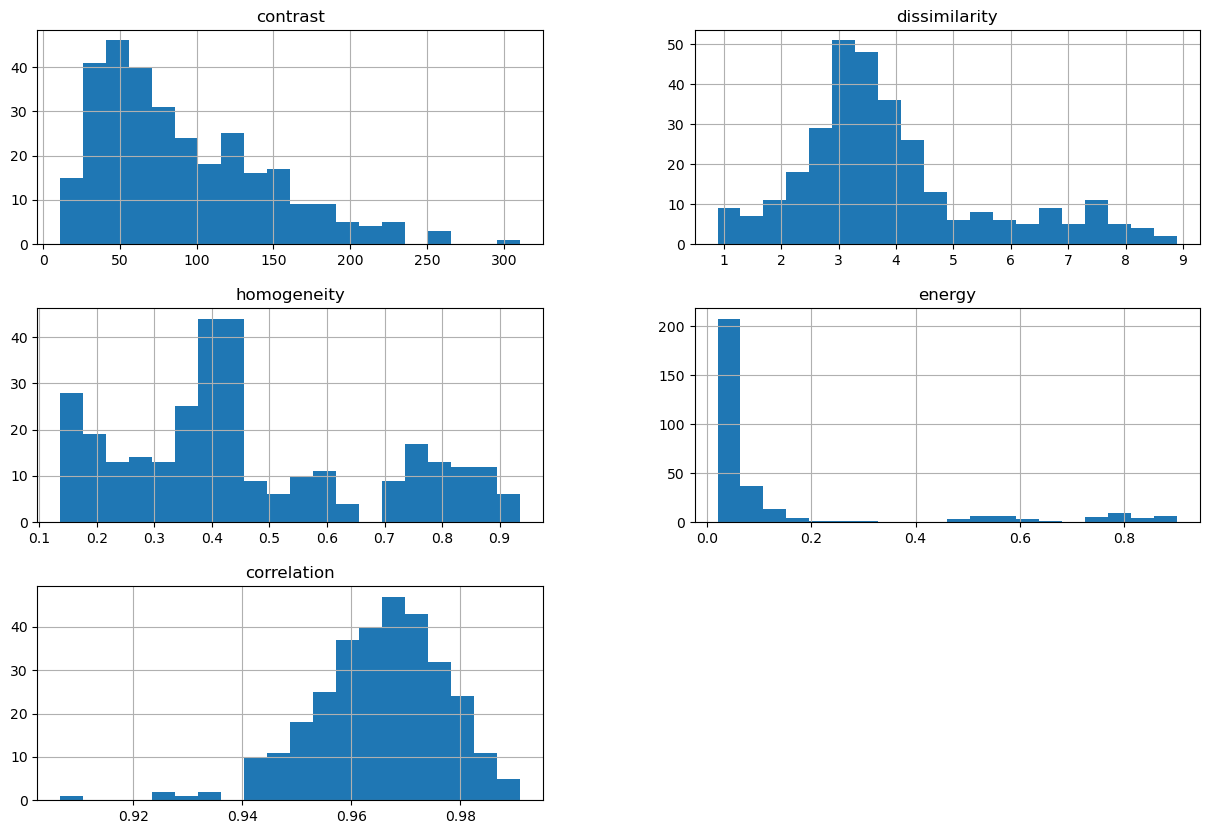

In [55]:
df.hist(bins=20, figsize=(15, 10))
plt.show()

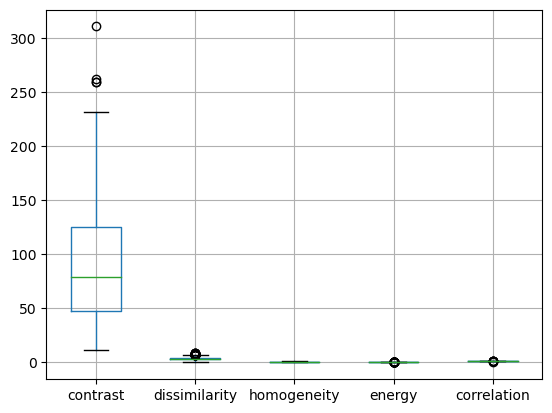

In [56]:
df.boxplot()
plt.show()

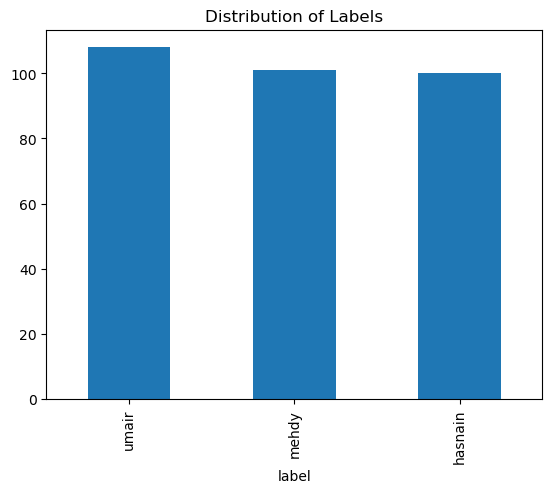

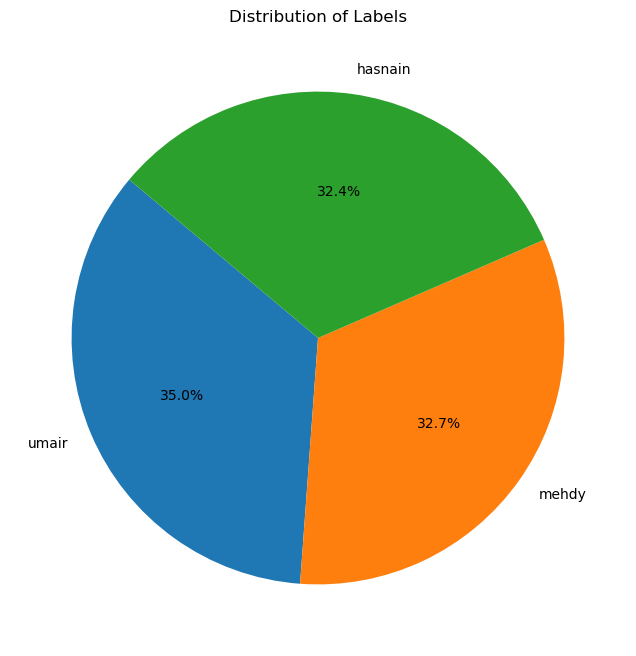

In [57]:
df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels')
plt.show()


label_counts = df['label'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Labels')
plt.show()


# Saving the KNN Model

In [58]:
from joblib import dump, load

# Save the trained model and scaler
model_filename = 'knn_model.joblib'
scaler_filename = 'scaler.joblib'

dump(grid_search.best_estimator_, model_filename)
dump(scaler, scaler_filename)

print(f"Model saved to {model_filename}")
print(f"Scaler saved to {scaler_filename}")

Model saved to knn_model.joblib
Scaler saved to scaler.joblib


The trained model and scaler are saved for future use, allowing for deployment in production environments or sharing with other team members. This model is integrated into an application or Webserver for further usage in prediction of writer.

# Methadology

   For our project, we have started by collecting a dataset comprising handwriting samples from three distinct categories: Umair, Hasnain, and Mehdy. These samples will encompass a variety of writing styles and variations to ensure comprehensive coverage. Subsequently, we will preprocess the data by normalizing or resizing the images, applying grayscale filtering to standardize the representation, and removing any noise or artifacts that may affect model performance. To ensure uniformity in input dimensions, we will scale them to be of equal dimensions. Following data preprocessing, we will extract features using grey-scale occurrence matrix filter which have proven effective in similar applications. Then, we will train a K-Nearest Neighbors (K-NN) classifier on the extracted features, tuning hyperparameters for optimal performance. Model evaluation will involve assessing performance metrics on a testing set to ensure robustness and generalization.

# Conclusion

The Handwriting Classification System offers a robust solution for identifying the author of handwritten notes. By leveraging image processing and machine learning techniques, the system achieves accurate and reliable results, with applications in various domains including forensic analysis, document verification, and handwriting recognition technologies.